# Inspeção de Qualidade - Benchmark de Modelos de Aprendizado de Máquina

## Objetivo
Testar a inspeção de qualidade automatizada usando modelos de aprendizado de máquina de visão computacional
Este repositório avaliará modelos de aprendizado de máquina (InceptionResNetv2, Xception, MobileNet e um modelo personalizado)

## Conjunto de dados

O conjunto de dados utilizado é da Pilot Technocast, uma empresa localizada em Gujarat, Índia, especializada na fabricação de produtos fundidos. O conjunto de dados, composto por 7348 imagens de vista superior de rotores de bomba submersível feitos de aço inoxidável por meio de um processo de moldagem em concha, foi disponibilizado publicamente por Ravirajsinh Dabhi. As imagens foram redimensionadas para 300 x 300 pixels e foram coletadas usando um kit de câmera Canon EOS 1300D sob iluminação estável. Os dados são pré-rotulados em duas categorias, a saber, 'def_front' e 'ok_front', representando produtos defeituosos e aceitáveis, respectivamente.

In [70]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image 
from keras.models import Sequential
from sklearn import metrics

In [71]:
# Usando a GPU em um Mac M1

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [72]:
# definindo variáveis de diretório
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

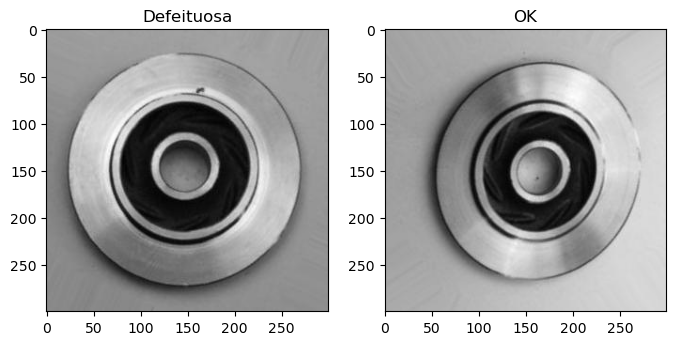

In [73]:
# Plotando imagens

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defeituosa')
axes[1].set_title('OK')
plt.show()

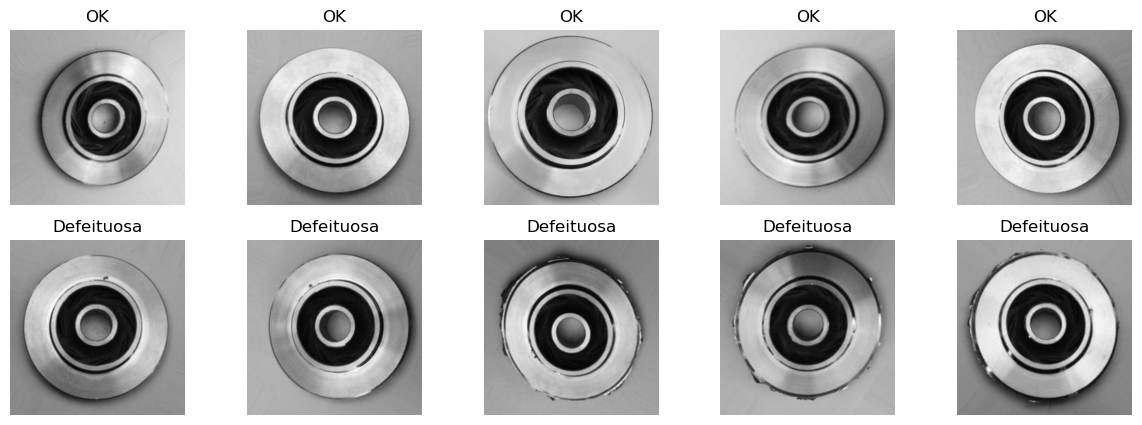

In [74]:
# 5 imagens de cada rótulo - conjunto de treinamento

# definir o número de imagens a plotar para cada rótulo
num_images = 5

# criacao de uma figura com duas linhas e num_images colunas
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))

# plot das imagens ok
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')

# plot das imagens defeituosas
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defeituosa')
    axs[1,i].axis('off')

# ajuste do espaçamento entre as subplots

plt.subplots_adjust(wspace=0.1, hspace=0.2)

# mostra do plot
plt.show()


### Análise exploratória dos dados


- Número de imagens


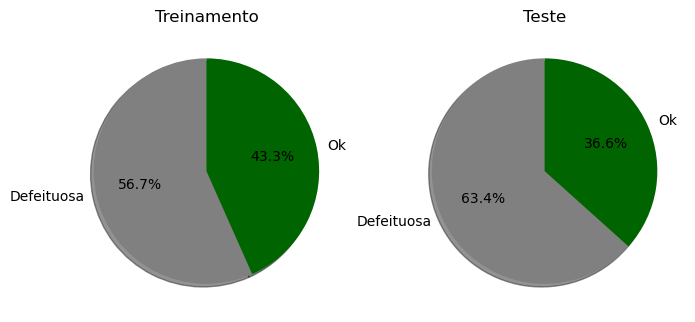

 Treinamento: Imagens Defeituosas 	: 3758
 Treinamento: Imagens Ok 		: 2875

 Teste: Imagens Defeituosas 	: 453
 Teste: Imagens Ok 		: 262


In [75]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defeituosa','Ok']
colors = ['grey', 'darkgreen']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Treinamento')
axes[1].set_title('Teste')
plt.show()

print(' Treinamento: Imagens Defeituosas \t: ' + str(len(os.listdir(train_defective))))
print(' Treinamento: Imagens Ok \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Teste: Imagens Defeituosas \t: ' + str(len(os.listdir(test_defective))))
print(' Teste: Imagens Ok \t\t: ' + str(len(os.listdir(test_ok))))

## Carregamento e pré-processamento dos dados

- Normalização 
- tamanho de entrada das imagens para a CNN (300x300)
- Definicao binaria e RGB

In [76]:
# Geral
# Utilizando IDG para carregar imagens do diretório
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idg = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [77]:
#Xception
# Utilizando IDG para carregar imagens do diretório
train_idgx = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgx = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizex = (300, 300)
batch_sizex = 64

arg_trainx = {'target_size': img_sizex,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizex}
arg_testx = {'target_size': img_sizex,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizex,
            'shuffle': False}

trainx = train_idgx.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validx = train_idgx.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testx  = test_idgx.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [78]:
#InceptionResnvetV2
# Utilizando IDG para carregar imagens do diretório
train_idgi = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgi = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizei = (300, 300)
batch_sizei = 64

arg_traini = {'target_size': img_sizei,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizei}
arg_testi = {'target_size': img_sizei,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizei,
            'shuffle': False}

traini = train_idgi.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validi = train_idgi.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testi  = test_idgi.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [79]:
#MobileNet
# Utilizando IDG para carregar imagens do diretório
train_idgm = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgm = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizem = (300, 300)
batch_sizem = 64

arg_trainm = {'target_size': img_sizem,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizem}
arg_testm = {'target_size': img_sizem,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizem,
            'shuffle': False}

trainm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testm  = test_idgm.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [80]:
#MobileNetV2
# Utilizando IDG para carregar imagens do diretório
train_idgm2 = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgm2 = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizem2 = (300, 300)
batch_sizem2 = 64

arg_trainm2 = {'target_size': img_sizem2,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizem2}
arg_testm2 = {'target_size': img_sizem2,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizem2,
            'shuffle': False}

trainm2 = train_idgm2.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validm2 = train_idgm2.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testm2  = test_idgm2.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## CNN
Modelos Xception, InceptionResnetV2, MobileNet e MobileNetV2

In [81]:
from tensorflow.keras.applications import Xception
xcept = Xception(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [82]:
from tensorflow.keras.applications import InceptionResNetV2
incresnv2 = InceptionResNetV2(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [83]:
from tensorflow.keras.applications import MobileNet
mobilenet = MobileNet(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [84]:
from tensorflow.keras.applications import MobileNetV2
mobilenetv2 = MobileNetV2(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

### Construindo os modelos

In [85]:
# Xception

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in xcept.layers:
    layer.trainable = False

cnnx = keras.Sequential([
    xcept,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnx.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnnx.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_8 (Flatten)         (None, 204800)            0         
                                                                 
 dense_16 (Dense)            (None, 256)               52429056  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 73,290,793
Trainable params: 52,429,313
Non-trainable params: 20,861,480
_________________________________________________________________


In [86]:
# InceptionResnetV2

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in inciresnv2.layers:
    layer.trainable = False

cnni = keras.Sequential([
    inciresnv2,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnni.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnni.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 98304)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               25166080  
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 79,503,073
Trainable params: 25,166,337
Non-trainable params: 54,336,736
_________________________________

In [87]:
# MobileNet

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in mobilenet.layers:
    layer.trainable = False

cnnm = keras.Sequential([
    mobilenet,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnm.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnnm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 9, 9, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 82944)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               21233920  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 24,463,041
Trainable params: 21,234,177
Non-trainable params: 3,228,864
_________________________________

In [88]:
# MobileNetV2

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in mobilenetv2.layers:
    layer.trainable = False

cnnm2 = keras.Sequential([
    mobilenetv2,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnm2.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnnm2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_11 (Flatten)        (None, 128000)            0         
                                                                 
 dense_22 (Dense)            (None, 256)               32768256  
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 35,026,497
Trainable params: 32,768,513
Non-trainable params: 2,257,984
_________________________________

### Treinando os modelos

In [89]:
historyx = cnnx.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-26 09:35:59.014049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 09:36:01.514923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 6.7634 - accuracy: 0.7396

2023-04-26 09:37:24.935382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 09:37:25.768501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 198s 10s/step - loss: 6.7634 - accuracy: 0.7396 - val_loss: 0.3720 - val_accuracy: 0.9191
Epoch 2/20
20/20 [==============================] - 132s 7s/step - loss: 0.3181 - accuracy: 0.9422 - val_loss: 0.1013 - val_accuracy: 0.9653
Epoch 3/20
20/20 [==============================] - 106s 5s/step - loss: 0.0882 - accuracy: 0.9789 - val_loss: 0.0415 - val_accuracy: 0.9874
Epoch 4/20
20/20 [==============================] - 107s 5s/step - loss: 0.0531 - accuracy: 0.9844 - val_loss: 0.0457 - val_accuracy: 0.9854
Epoch 5/20
20/20 [==============================] - 103s 5s/step - loss: 0.0618 - accuracy: 0.9859 - val_loss: 0.0304 - val_accuracy: 0.9925
Epoch 6/20
20/20 [==============================] - 104s 5s/step - loss: 0.0229 - accuracy: 0.9937 - val_loss: 0.0400 - val_accuracy: 0.9910
Epoch 7/20
20/20 [==============================] - 108s 6s/step - loss: 0.0228 - accuracy: 0.9920 - val_loss: 0.0251 - val_accuracy: 0.9930
Epoch 8/20
20/20 [=====

In [90]:
historyi = cnni.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-26 10:16:34.911832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 10:16:43.936202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 12.6715 - accuracy: 0.5898

2023-04-26 10:17:57.582052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 10:17:58.894709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 189s 9s/step - loss: 12.6715 - accuracy: 0.5898 - val_loss: 1.1952 - val_accuracy: 0.7547
Epoch 2/20
20/20 [==============================] - 145s 8s/step - loss: 0.6036 - accuracy: 0.8766 - val_loss: 0.1225 - val_accuracy: 0.9623
Epoch 3/20
20/20 [==============================] - 144s 7s/step - loss: 0.1116 - accuracy: 0.9641 - val_loss: 0.0995 - val_accuracy: 0.9739
Epoch 4/20
20/20 [==============================] - 154s 8s/step - loss: 0.0425 - accuracy: 0.9883 - val_loss: 0.0402 - val_accuracy: 0.9889
Epoch 5/20
20/20 [==============================] - 144s 7s/step - loss: 0.0279 - accuracy: 0.9930 - val_loss: 0.0377 - val_accuracy: 0.9879
Epoch 6/20
20/20 [==============================] - 144s 7s/step - loss: 0.0229 - accuracy: 0.9937 - val_loss: 0.0322 - val_accuracy: 0.9915
Epoch 7/20
20/20 [==============================] - 137s 7s/step - loss: 0.0249 - accuracy: 0.9930 - val_loss: 0.0730 - val_accuracy: 0.9693
Epoch 8/20
20/20 [=====

In [91]:
historym = cnnm.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-26 11:06:34.220000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:06:35.891495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 11.3661 - accuracy: 0.6234

2023-04-26 11:06:52.789934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:06:53.092002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 40s 2s/step - loss: 11.3661 - accuracy: 0.6234 - val_loss: 0.4786 - val_accuracy: 0.8884
Epoch 2/20
20/20 [==============================] - 35s 2s/step - loss: 0.3618 - accuracy: 0.9209 - val_loss: 0.0988 - val_accuracy: 0.9668
Epoch 3/20
20/20 [==============================] - 31s 2s/step - loss: 0.0592 - accuracy: 0.9859 - val_loss: 0.0452 - val_accuracy: 0.9899
Epoch 4/20
20/20 [==============================] - 32s 2s/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.0363 - val_accuracy: 0.9894
Epoch 5/20
20/20 [==============================] - 31s 2s/step - loss: 0.0254 - accuracy: 0.9968 - val_loss: 0.0307 - val_accuracy: 0.9945
Epoch 6/20
20/20 [==============================] - 30s 2s/step - loss: 0.0187 - accuracy: 0.9953 - val_loss: 0.0259 - val_accuracy: 0.9950
Epoch 7/20
20/20 [==============================] - 31s 2s/step - loss: 0.0237 - accuracy: 0.9930 - val_loss: 0.0236 - val_accuracy: 0.9945
Epoch 8/20
20/20 [============

In [92]:
historym2 = cnnm2.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-26 11:16:50.049251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:16:51.675478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 11.1459 - accuracy: 0.7085

2023-04-26 11:17:16.570177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:17:17.061287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 56s 3s/step - loss: 11.1459 - accuracy: 0.7085 - val_loss: 1.7494 - val_accuracy: 0.8894
Epoch 2/20
20/20 [==============================] - 42s 2s/step - loss: 0.9147 - accuracy: 0.9414 - val_loss: 0.2090 - val_accuracy: 0.9804
Epoch 3/20
20/20 [==============================] - 42s 2s/step - loss: 0.2997 - accuracy: 0.9797 - val_loss: 0.1084 - val_accuracy: 0.9889
Epoch 4/20
20/20 [==============================] - 40s 2s/step - loss: 0.1149 - accuracy: 0.9852 - val_loss: 0.0872 - val_accuracy: 0.9899
Epoch 5/20
20/20 [==============================] - 44s 2s/step - loss: 0.1173 - accuracy: 0.9867 - val_loss: 0.0685 - val_accuracy: 0.9945
Epoch 6/20
20/20 [==============================] - 41s 2s/step - loss: 0.0326 - accuracy: 0.9953 - val_loss: 0.0576 - val_accuracy: 0.9920
Epoch 7/20
20/20 [==============================] - 41s 2s/step - loss: 0.0269 - accuracy: 0.9945 - val_loss: 0.0795 - val_accuracy: 0.9945
Epoch 8/20
20/20 [============

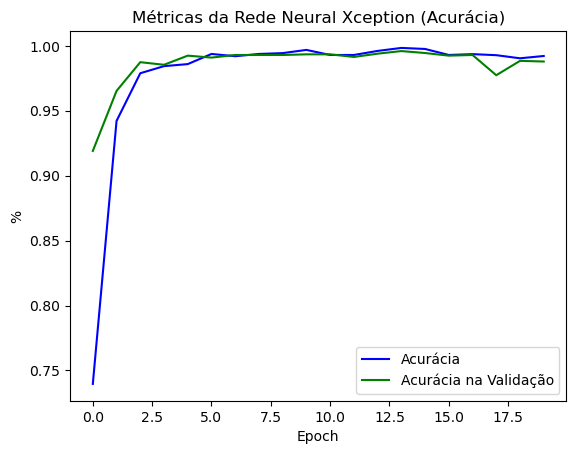

In [93]:
plt.plot(historyx.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historyx.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural Xception (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

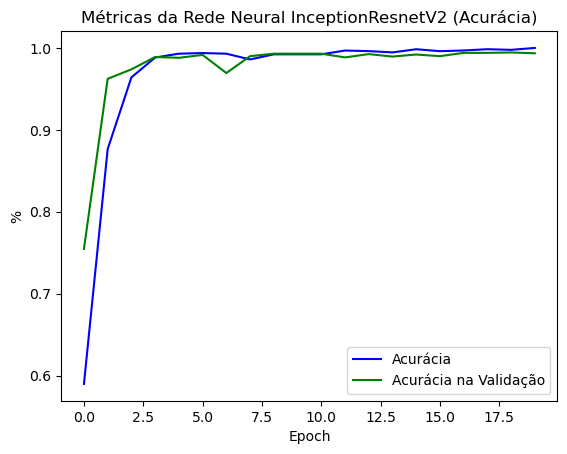

In [94]:
plt.plot(historyi.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historyi.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural InceptionResnetV2 (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

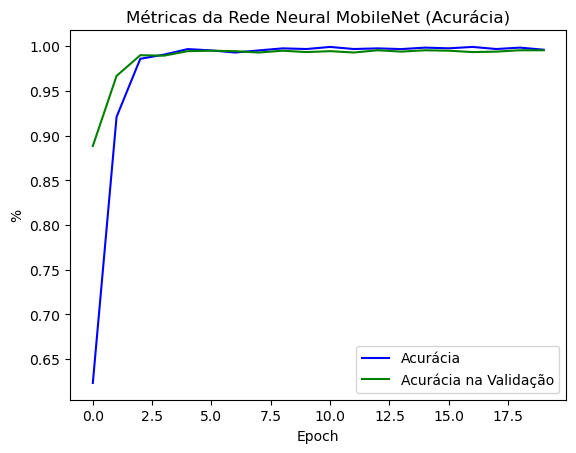

In [95]:
plt.plot(historym.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historym.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural MobileNet (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

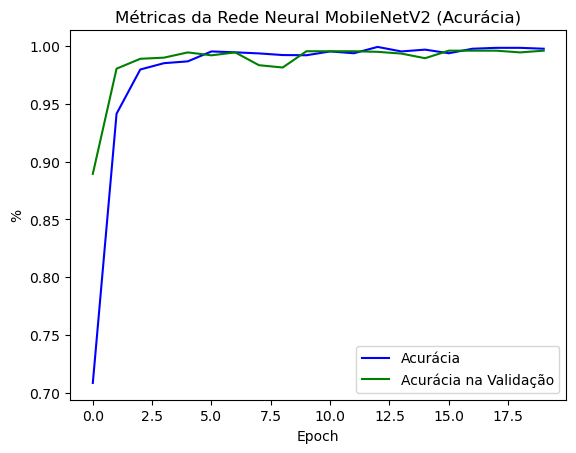

In [96]:
plt.plot(historym2.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historym2.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural MobileNetV2 (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

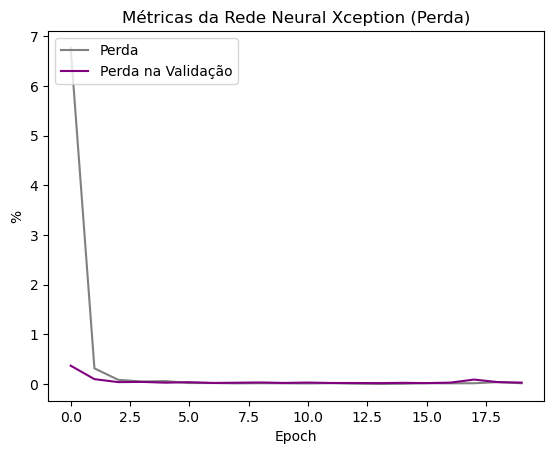

In [97]:
plt.plot(historyx.history['loss'], color='grey', label='Perda')
plt.plot(historyx.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural Xception (Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

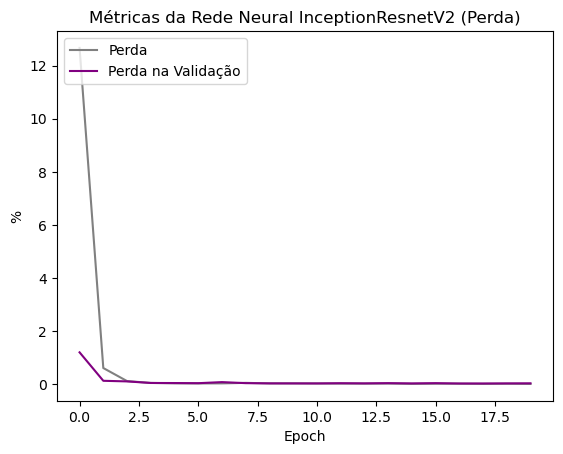

In [98]:
plt.plot(historyi.history['loss'], color='grey', label='Perda')
plt.plot(historyi.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural InceptionResnetV2 (Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

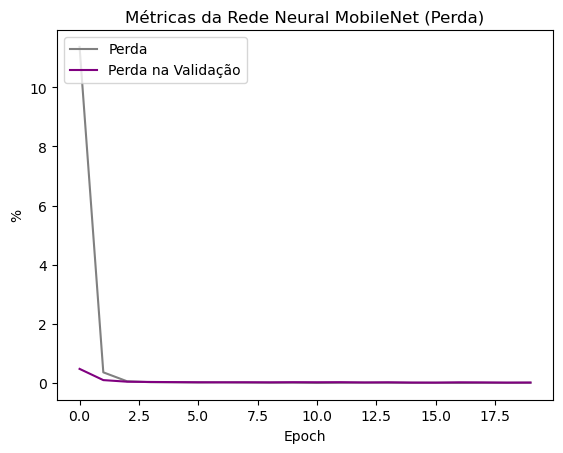

In [99]:
plt.plot(historym.history['loss'], color='grey', label='Perda')
plt.plot(historym.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural MobileNet (Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

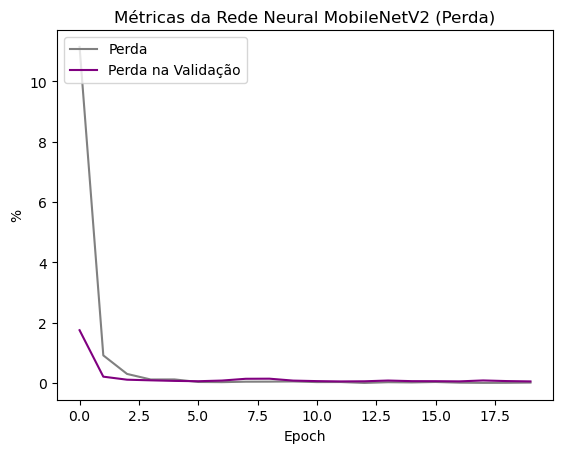

In [100]:
plt.plot(historym2.history['loss'], color='grey', label='Perda')
plt.plot(historym2.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural MobileNetV2 (Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Testando e avaliando

In [101]:
y_predx = cnnx.predict(test)
y_predx = (y_predx >= 0.5).reshape(-1,)

2023-04-26 11:29:48.485013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:29:48.993696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 28s 2s/step


In [102]:
y_predi = cnni.predict(test)
y_predi = (y_predi >= 0.5).reshape(-1,)

2023-04-26 11:30:17.320563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:30:31.124205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 67s 3s/step


In [103]:
y_predm = cnnm.predict(test)
y_predm = (y_predm >= 0.5).reshape(-1,)

2023-04-26 11:31:24.431103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:31:24.768538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 8s 550ms/step


In [104]:
y_predm2 = cnnm2.predict(test)
y_predm2 = (y_predm2 >= 0.5).reshape(-1,)

2023-04-26 11:31:32.441994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:31:32.766945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 13s 861ms/step


In [105]:
y_actualx = test.classes[test.index_array]

In [106]:
y_actuali = test.classes[test.index_array]

In [107]:
y_actualm = test.classes[test.index_array]

In [108]:
y_actualm2 = test.classes[test.index_array]

#### Matriz de confusão

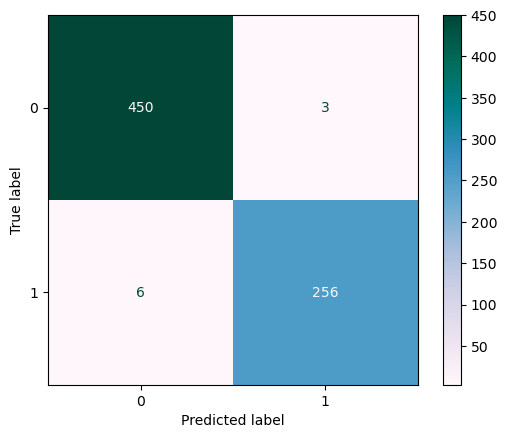

In [109]:
cmx = metrics.confusion_matrix(y_actualx, y_predx)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmx)
disp.plot(cmap='PuBuGn')
plt.show()

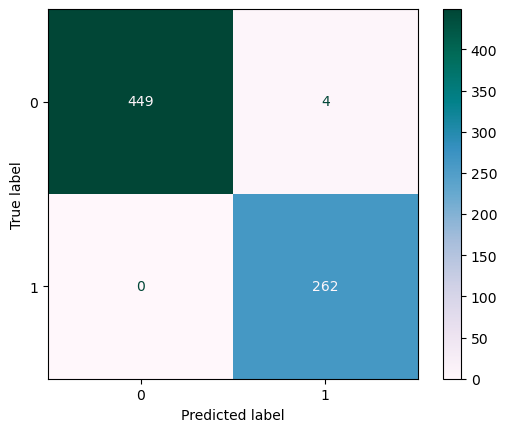

In [110]:
cmi = metrics.confusion_matrix(y_actuali, y_predi)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmi)
disp.plot(cmap='PuBuGn')
plt.show()

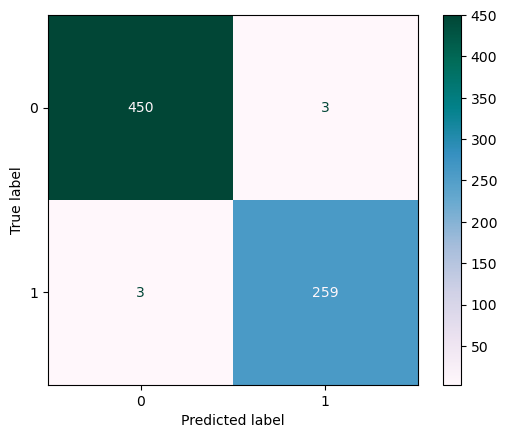

In [111]:
cmm = metrics.confusion_matrix(y_actualm, y_predm)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmm)
disp.plot(cmap='PuBuGn')
plt.show()

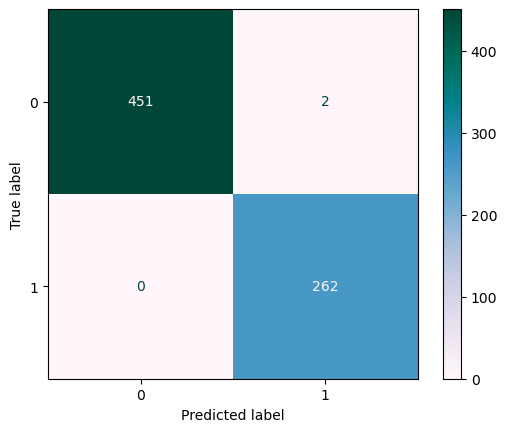

In [112]:
cmm2 = metrics.confusion_matrix(y_actualm2, y_predm2)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmm2)
disp.plot(cmap='PuBuGn')
plt.show()

#### Relatório de classificação

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actualx, y_predx, digits=4))

              precision    recall  f1-score   support

           0     0.9868    0.9934    0.9901       453
           1     0.9884    0.9771    0.9827       262

    accuracy                         0.9874       715
   macro avg     0.9876    0.9852    0.9864       715
weighted avg     0.9874    0.9874    0.9874       715



In [125]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actuali, y_predi, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9912    0.9956       453
           1     0.9850    1.0000    0.9924       262

    accuracy                         0.9944       715
   macro avg     0.9925    0.9956    0.9940       715
weighted avg     0.9945    0.9944    0.9944       715



In [115]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actualm, y_predm, digits=4))

              precision    recall  f1-score   support

           0     0.9934    0.9934    0.9934       453
           1     0.9885    0.9885    0.9885       262

    accuracy                         0.9916       715
   macro avg     0.9910    0.9910    0.9910       715
weighted avg     0.9916    0.9916    0.9916       715



In [116]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actualm2, y_predm2, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9956    0.9978       453
           1     0.9924    1.0000    0.9962       262

    accuracy                         0.9972       715
   macro avg     0.9962    0.9978    0.9970       715
weighted avg     0.9972    0.9972    0.9972       715



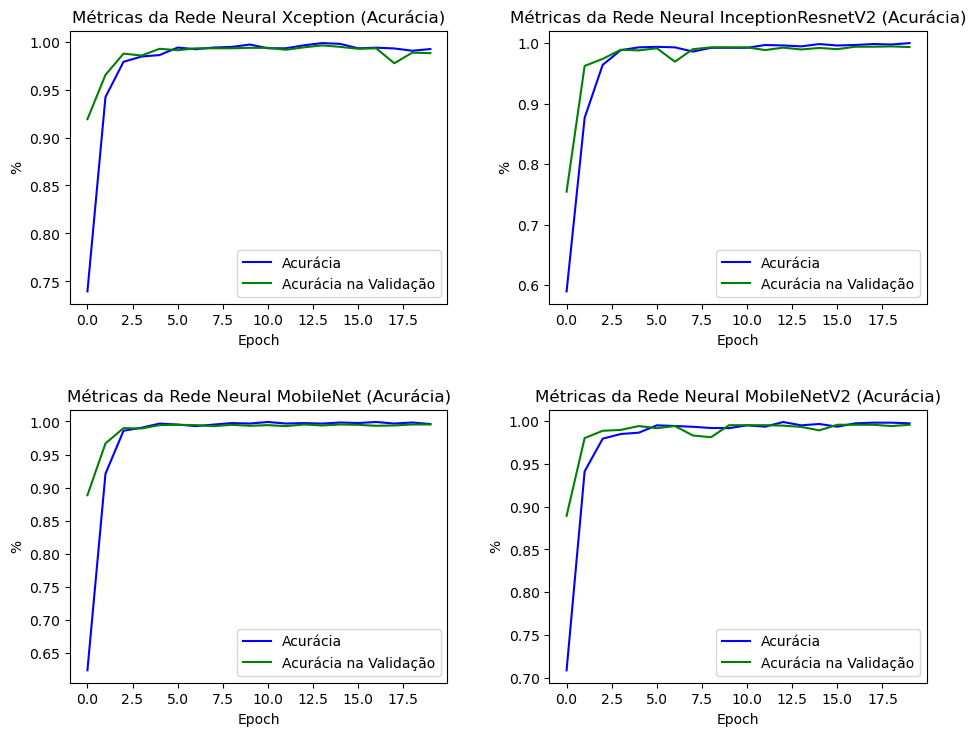

In [174]:
# Colocando os graficos juntos

# Define the figure and axes objects

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot the first graph on the top-left axes
axs[0, 0].plot(historyx.history['accuracy'], color='blue', label='Acurácia')
axs[0, 0].plot(historyx.history['val_accuracy'], color='green', label='Acurácia na Validação')
axs[0, 0].set_title('Métricas da Rede Neural Xception (Acurácia)')
axs[0, 0].set_ylabel('%')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc="lower right")

# Plot the second graph on the top-right axes
axs[0, 1].plot(historyi.history['accuracy'], color='blue', label='Acurácia')
axs[0, 1].plot(historyi.history['val_accuracy'], color='green', label='Acurácia na Validação')
axs[0, 1].set_title('Métricas da Rede Neural InceptionResnetV2 (Acurácia)')
axs[0, 1].set_ylabel('%')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc="lower right")

# Plot the third graph on the bottom-left axes
axs[1, 0].plot(historym.history['accuracy'], color='blue', label='Acurácia')
axs[1, 0].plot(historym.history['val_accuracy'], color='green', label='Acurácia na Validação')
axs[1, 0].set_title('Métricas da Rede Neural MobileNet (Acurácia)')
axs[1, 0].set_ylabel('%')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc="lower right")

# Plot the fourth graph on the bottom-right axes
axs[1, 1].plot(historym2.history['accuracy'], color='blue', label='Acurácia')
axs[1, 1].plot(historym2.history['val_accuracy'], color='green', label='Acurácia na Validação')
axs[1, 1].set_title('Métricas da Rede Neural MobileNetV2 (Acurácia)')
axs[1, 1].set_ylabel('%')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc="lower right")

# Adjust the layout and spacing of the subplots
fig.tight_layout(pad=3.0)

# Display the plot


plt.show()


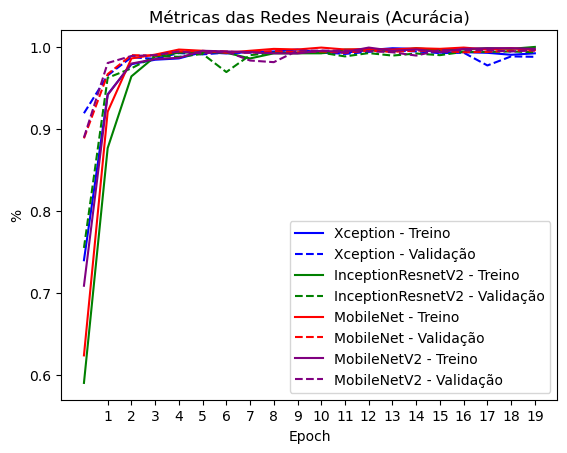

In [123]:

# Plot the curves for Xception model
plt.plot(historyx.history['accuracy'], color='blue', label='Xception - Treino')
plt.plot(historyx.history['val_accuracy'], color='blue', linestyle='--', label='Xception - Validação')

# Plot the curves for InceptionResnetV2 model
plt.plot(historyi.history['accuracy'], color='green', label='InceptionResnetV2 - Treino')
plt.plot(historyi.history['val_accuracy'], color='green', linestyle='--', label='InceptionResnetV2 - Validação')

# Plot the curves for MobileNet model
plt.plot(historym.history['accuracy'], color='red', label='MobileNet - Treino')
plt.plot(historym.history['val_accuracy'], color='red', linestyle='--', label='MobileNet - Validação')

# Plot the curves for MobileNetV2 model
plt.plot(historym2.history['accuracy'], color='purple', label='MobileNetV2 - Treino')
plt.plot(historym2.history['val_accuracy'], color='purple', linestyle='--', label='MobileNetV2 - Validação')

# Set the title, axes labels, and legend
plt.title('Métricas das Redes Neurais (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")

# Display the plot
plt.xticks(range(1, len(historyx.history['accuracy'])))
plt.show()


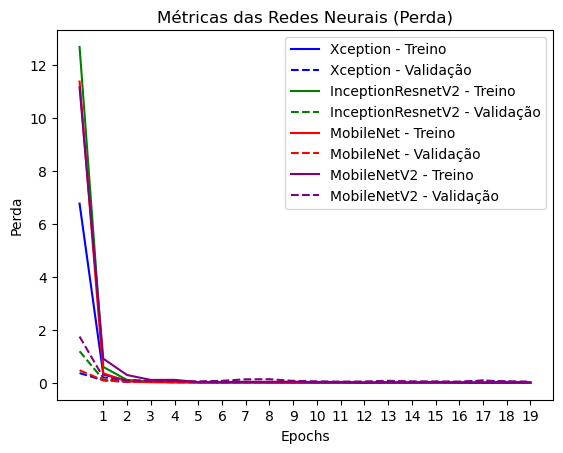

In [124]:
import matplotlib.pyplot as plt

# Plot the curves for Xception model
plt.plot(historyx.history['loss'], color='blue', label='Xception - Treino')
plt.plot(historyx.history['val_loss'], color='blue', linestyle='--', label='Xception - Validação')

# Plot the curves for InceptionResnetV2 model
plt.plot(historyi.history['loss'], color='green', label='InceptionResnetV2 - Treino')
plt.plot(historyi.history['val_loss'], color='green', linestyle='--', label='InceptionResnetV2 - Validação')

# Plot the curves for MobileNet model
plt.plot(historym.history['loss'], color='red', label='MobileNet - Treino')
plt.plot(historym.history['val_loss'], color='red', linestyle='--', label='MobileNet - Validação')

# Plot the curves for MobileNetV2 model
plt.plot(historym2.history['loss'], color='purple', label='MobileNetV2 - Treino')
plt.plot(historym2.history['val_loss'], color='purple', linestyle='--', label='MobileNetV2 - Validação')

# Set the title, axes labels, and legend
plt.title('Métricas das Redes Neurais (Perda)')
plt.ylabel('Perda')
plt.xlabel('Epochs')
plt.legend(loc="upper right")

# Display the plot
plt.xticks(range(1, len(historyx.history['loss'])))
plt.show()


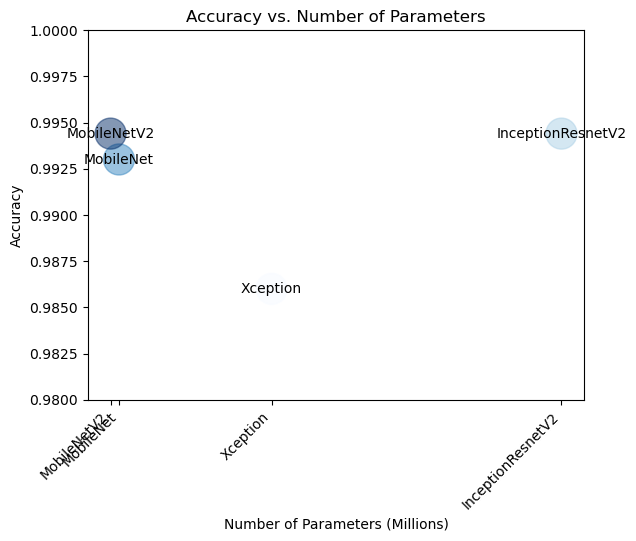

In [168]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Xception', 'InceptionResnetV2', 'MobileNet', 'MobileNetV2']
params = [20.86, 54.34, 3.23, 2.26]
accuracies = [0.9860, 0.9944, 0.9930, 0.9944]

plt.scatter(params, accuracies, s=500, alpha=0.5, c=np.arange(len(models)), cmap='Blues')
plt.xticks(params, models, rotation=45, ha='right')
plt.ylim(0.98, 1.00)
plt.ylabel('Accuracy')
plt.xlabel('Number of Parameters (Millions)')
plt.title('Accuracy vs. Number of Parameters')

for i, model in enumerate(models):
    plt.annotate(model, xy=(params[i], accuracies[i]), ha='center', va='center')


plt.show()


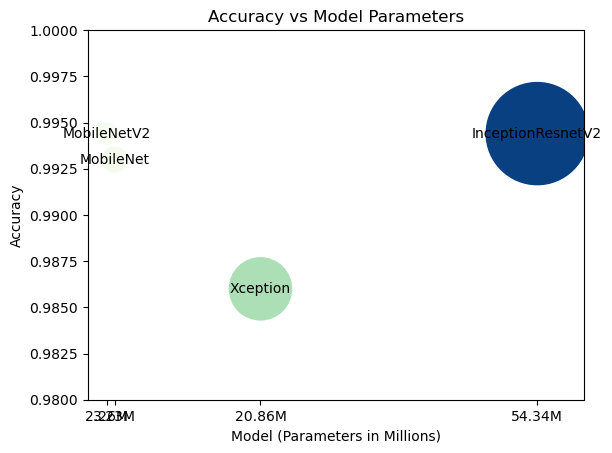

In [170]:
import matplotlib.pyplot as plt
import numpy as np
 
models = ['Xception', 'InceptionResnetV2', 'MobileNet', 'MobileNetV2']
params = [20.86, 54.34, 3.23, 2.26]
accuracies = [0.9860, 0.9944, 0.9930, 0.9944]
sizes = [2000, 5400, 320, 230]
 
fig, ax = plt.subplots()
ax.set_xlim(0, max(params) + 2)
ax.set_ylim(0.97, 1.00)
ax.set_xlabel('Model (Parameters in Millions)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Parameters for 4 Models')
 
scatter = ax.scatter(params, accuracies, c=params, cmap='GnBu', s=sizes)
for i, txt in enumerate(models):
    ax.annotate(txt, (params[i], accuracies[i]), ha='center', va='center')

ax.set_xlim(left=0, right=60)
ax.set_xticks(params)
ax.set_xticklabels([str(p) + 'M' for p in params])

ax.set_ylim(bottom=0.98, top=1.0)
ax.set_ylabel('Accuracy')


plt.title('Accuracy vs Model Parameters')

plt.show()


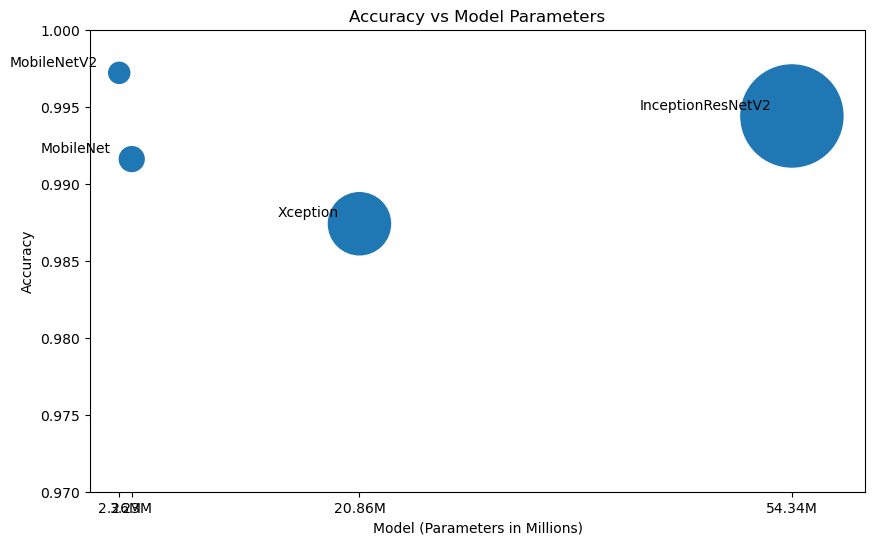

In [177]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Xception', 'InceptionResNetV2', 'MobileNet', 'MobileNetV2']
params = [20.86, 54.34, 3.23, 2.26]
accuracy = [0.9874, 0.9944, 0.9916, 0.9972]
sizes = [2000, 5400, 320, 230]

fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(params, accuracy, s=sizes, cmap='cool')

for i, txt in enumerate(model_names):
    ax.annotate(txt, (params[i], accuracy[i]), xytext=(-15, 5), textcoords='offset points', ha='right')

ax.set_xlim(left=0, right=60)
ax.set_xticks(params)
ax.set_xticklabels([str(p) + 'M' for p in params])
ax.set_xlabel('Model (Parameters in Millions)')


ax.set_ylim(bottom=0.97, top=1.0)
ax.set_ylabel('Accuracy')


plt.title('Accuracy vs Model Parameters')
plt.show()


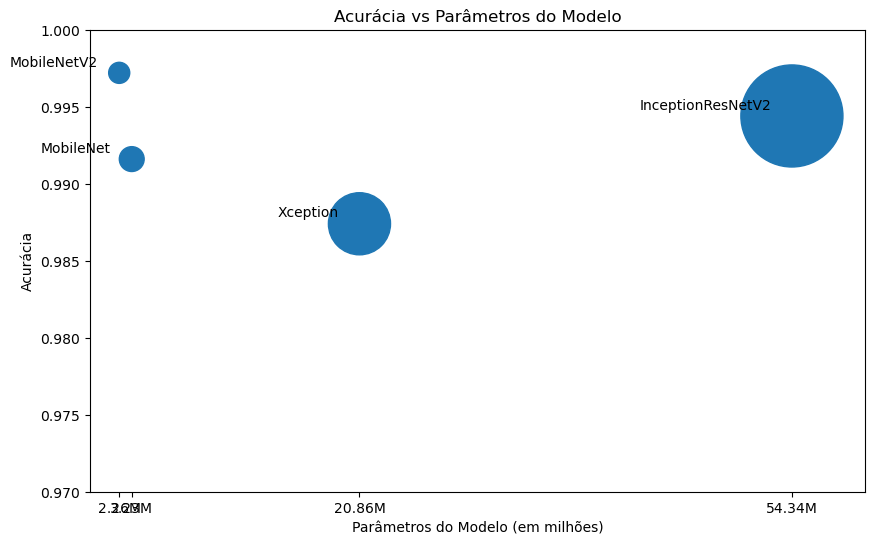

In [183]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Xception', 'InceptionResNetV2', 'MobileNet', 'MobileNetV2']
params = [20.86, 54.34, 3.23, 2.26]
accuracy = [0.9874, 0.9944, 0.9916, 0.9972]
sizes = [2000, 5400, 320, 230]

fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(params, accuracy, s=sizes, cmap='cool')

for i, txt in enumerate(model_names):
    ax.annotate(txt, (params[i], accuracy[i]), xytext=(-15, 5), textcoords='offset points', ha='right')

ax.set_xlim(left=0, right=60)
ax.set_xticks(params)
ax.set_xticklabels([str(p) + 'M' for p in params])
ax.set_xlabel('Parâmetros do Modelo (em milhões)')


ax.set_ylim(bottom=0.97, top=1.0)
ax.set_ylabel('Acurácia')


plt.title('Acurácia vs Parâmetros do Modelo')
plt.show()


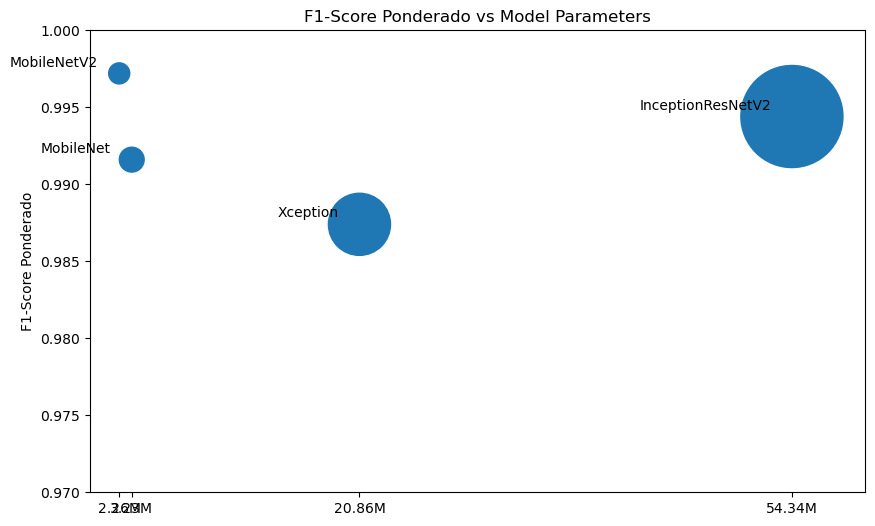

In [176]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Xception', 'InceptionResNetV2', 'MobileNet', 'MobileNetV2']
params = [20.86, 54.34, 3.23, 2.26]
f1sc = [0.9874, 0.9944, 0.9916, 0.9972]
sizes = [2000, 5400, 320, 230]

fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(params, f1sc, s=sizes, cmap='cool')

for i, txt in enumerate(model_names):
    ax.annotate(txt, (params[i], f1sc[i]), xytext=(-15, 5), textcoords='offset points', ha='right')

ax.set_xlim(left=0, right=60)
ax.set_xticks(params)
ax.set_xticklabels([str(p) + 'M' for p in params])

ax.set_ylim(bottom=0.97, top=1.0)
ax.set_ylabel('F1-Score Ponderado')


plt.title('F1-Score Ponderado vs Model Parameters')
plt.show()


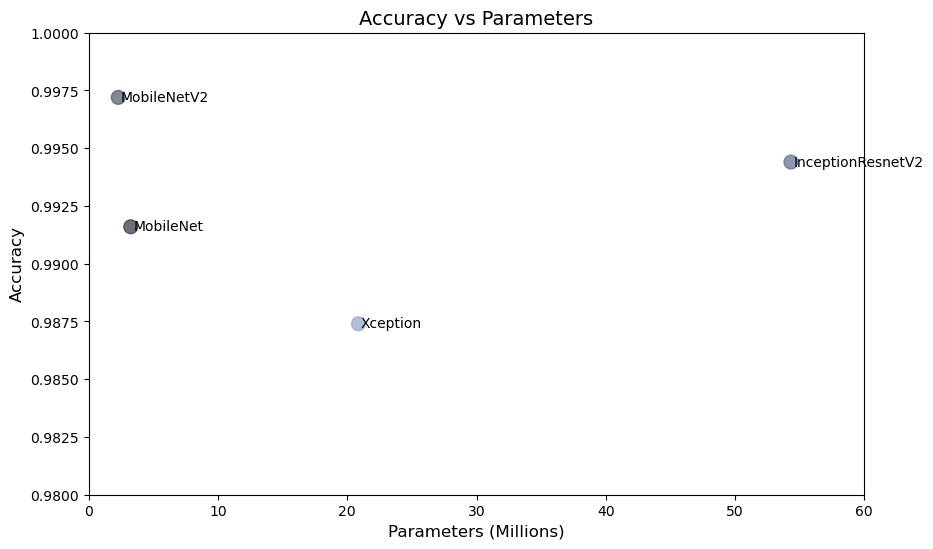

In [185]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Xception', 'InceptionResnetV2', 'MobileNet', 'MobileNetV2']
params = [20.86, 54.34, 3.23, 2.26]
accuracies = [0.9874, 0.9944, 0.9916, 0.9972]
colors = ['#91A5CC', '#5C6B8F', '#2E3440', '#4C566A']
sizes = [acc * 100 for acc in accuracies]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(params, accuracies, s=sizes, alpha=0.7, color=colors)

# Labels
for i, model in enumerate(models):
    plt.text(params[i]+0.2, accuracies[i], model, ha='left', va='center', fontsize=10)

plt.xlabel('Parameters (Millions)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Parameters', fontsize=14)


plt.xlim(0, 60)
plt.ylim(0.98, 1.0)

plt.show()
